## Lab session: Introduction to supervised learning
### 1. Utilisation de ScikitLearn avec Python 3

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

## 2. Expériences de reconnaissance de chiffres manuscrits
### 2.1 Chargement de la base de données MNIST
Pour nos premières expériences, nous allons utiliser la base de données MNIST qui comporte les descriptions de chiffres manuscrits en format 28 x 28, soit 784 pixels, et les étiquettes associées. La base contient en tout 70 000 exemples, c’est-à-dire 7000 exemples de chaque chiffre.

Nous chargeons d’abord la base, puis nous examinons l’un des exemples qu’elle contient.

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', cache=False)

In [5]:
#mnist

In [6]:
X, y = mnist["data"], mnist ["target"]
X=X.to_numpy()
y=y.to_numpy()

In [7]:
X.shape

(70000,)

In [8]:
y.shape

(70000,)

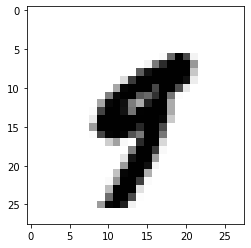

In [10]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
some_digit = X[36000]
some_digit_image = some_digit.reshape(28,28)
plt.imshow(some_digit_image,cmap = matplotlib.cm.binary,interpolation = "nearest")

## 2.2 Premier apprentissage
Nous sélectionnons 60 000 exemples pour l’apprentissage et 10 000 pour le test (la base MNIST est organisée de cette manière).

Pour les tests à venir, il est important de garantir que les exemples sont aléatoirement répartis dans la base d’apprentissage afin que tout tirage d’un sous-ensemble comporte à peu près la même proportion de chaque chiffre.

In [14]:
X_train , X_test , y_train , y_test = X[:60000] , X[10000:] , y [:60000] , y [10000:]

In [15]:
shuffle_index = np.random.permutation(60000)

In [16]:
X_train , y_train = X_train[shuffle_index], y_train[shuffle_index]

Nous allons d’abord apprendre des classifieurs binaires, à deux classes. Ici, nous choisissons d’entraîner un classifieur à apprendre à reconnaître les 5 contre tous les autres chiffres.

In [19]:
y_train = np.array(list(map(int, y_train)))
y_test = np.array(list(map(int,y_test)))

In [20]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [21]:
sum(y_train_5)

5421

Nous avons chargé un classifieur linéaire binaire avec descente de gradient stochastique.

Ici, par défaut, l’apprentissage s’arrête après 1000 itérations maximum ou bien quand la progression de l’erreur d’apprentissage d’une itération à la suivante vaut moins que  10−3 . Voir l’url : https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html pour les détails du paramétrage de cette fonction.

Nous entrainons ensuite le classifieur sur les données d’apprentissage, et nous le testons sur l’exemple de 9 déjà vu (some_digit).

In [23]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

La méthode la plus simple est de calculer l'accuracy du modèle

In [24]:
sgd_clf.predict([some_digit])

array([False])

Une méthode courante d’évaluation d’un apprentissage supervisé de concept est la validation croisée. Ici, nous utilisons une validation croisée à trois plis. Une valeur courante est 10 plis. La fonction cross_val_score calcule les erreurs associées à chaque pli. Vous pouvez ensuite en calculer la moyenne.

In [26]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring = "accuracy")

array([0.95015, 0.80895, 0.96435])

Ces taux de bonne prédiction paraissent tout à fait impressionnants pour un apprentissage par une méthode linéaire.

*Mais que ferait un classifieur qui se contenterait de toujours prédire not 5 ?*

In [27]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y = None):
        pass
    
    def predict(self,X):
        return np.zeros((len(X),1), dtype=bool)

In [28]:
never_5_clf = Never5Classifier()
y_train_pred = cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring = "accuracy") #cross validation
y_train_pred

array([0.90955, 0.9105 , 0.9089 ])

*Pas* très étonnant. Mais cela relativise la performance apparemment excellente du classifieur
linéaire !

### Confusion Matrix

In [29]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [30]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_train_5, y_train_pred)
cm

array([[49728,  4851],
       [  680,  4741]], dtype=int64)

Puis celle que l’on obtiendrait avec un classifieur parfait (qui prédit la classe donnée par la base
d’exemples).

In [31]:
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

### Précision et rappel

In [33]:
from sklearn.metrics import precision_score, recall_score

In [34]:
precision_score(y_train_5, y_train_pred)

0.49426605504587157

In [35]:
recall_score(y_train_5, y_train_pred)

0.8745618889503781

In [36]:
from sklearn.metrics import f1_score

In [38]:
f1_score(y_train_5, y_train_pred)

0.6315859588356757

### Le compromis précision vs. rappel

In [39]:
y_scores = sgd_clf.decision_function([some_digit])

In [40]:
y_scores

array([-7535.62902135])

In [41]:
threshold = 0

In [42]:
y_some_digit_pred = (y_scores > threshold)

In [43]:
y_some_digit_pred

array([False])

In [45]:
threshold = 210000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [46]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

In [47]:
from sklearn.metrics import precision_recall_curve

In [48]:
y_scores.shape

(60000,)

In [50]:
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [51]:
def plot_precision_recall_vs_thresholds(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g--", label="Recall", linewidth=2)
    plt.xlabel("Threshold", fontsize = 16)
    plt.legend(loc = "upper left", fontsize = 16)
    plt.ylim([0,1])

In [52]:
plt.figure(figsize=(8,4))

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

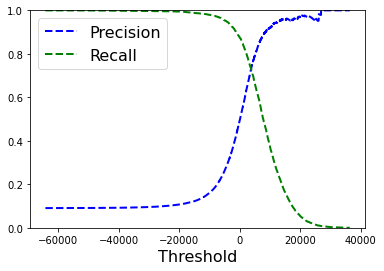

In [53]:
plot_precision_recall_vs_thresholds(precisions, recalls, thresholds)

Il est également intéressant de tracer la figure précision en fonction du rappel !

### Courbe ROC

In [54]:
my_y_scores = y_scores

In [55]:
from sklearn.metrics import roc_curve

In [56]:
fpr, tpr, thresholds = roc_curve(y_train_5, my_y_scores)

In [57]:
def plot_roc_curve(fpr, tpr, label = None):
    plt.plot(fpr, tpr, linewidth=2, label = label)
    plt.plot([0,1],[0,1], 'k--')
    plt.axis([0,1,0,1])
    plt.xlabel('FPR', fontsize = 16)
    plt.ylabel('TPR', fontsize = 16)

In [58]:
plt.figure(figsize=(8,4))

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

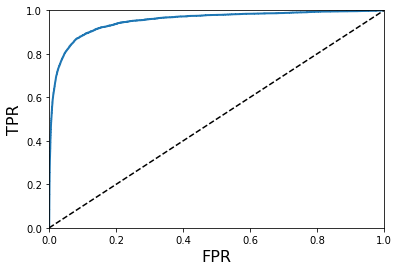

In [60]:
plot_roc_curve(fpr, tpr) #Printing ROC Curve

### Performance globale du prédicteur en multiclass

In [61]:
sgd_clf.fit(X_train, y_train)
predictions = sgd_clf.predict(X_test)

In [63]:
score = sgd_clf.score(X_test, y_test)

In [64]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train, cv = 3, scoring = "accuracy")

array([0.87775, 0.8719 , 0.87305])

In [65]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf,X_train,y_train, cv=3)

### Matrice de confusion

In [66]:
from sklearn.metrics import confusion_matrix
cm2 = confusion_matrix(y_train, y_train_pred)

In [70]:
#pip install seaborn

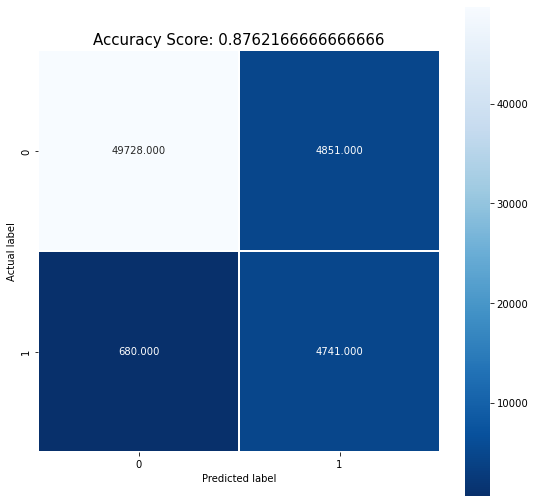

In [72]:
import seaborn as sns

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);
plt.savefig('toy_Digits_ConfusionSeabornCodementor.png')
#plt.show();

## Precision et rappel

In [79]:
from sklearn.metrics import precision_score, recall_score

In [73]:
precision_score(y_train, y_train_pred, average = 'micro')

0.8742333333333333

In [74]:
recall_score(y_train, y_train_pred, average = 'micro')

0.8742333333333333

In [75]:
y_scores = cross_val_predict(sgd_clf, X_train,y_train, cv = 3, method = "decision_function")

## Exercice : regression logistique
Soit les données digits suivants, en utilisant la librairie scikitlearn, effectuer une regression logistique en suivant les étapes vues au dessus.

Appliquez différentes régularisations (ridg,lasso par exemple, voir documentation scikitlearn), et effectuer une recherche d'hyperparamètres: cf https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

In [76]:
%matplotlib inline
from sklearn.datasets import load_digits
digits = load_digits()

In [77]:
# Print to show there are 1797 images (8 by 8 images for a dimensionality of 64)
print("Image Data Shape" , digits.data.shape)

# Print to show there are 1797 labels (integers from 0-9)
print("Label Data Shape", digits.target.shape)

Image Data Shape (1797, 64)
Label Data Shape (1797,)


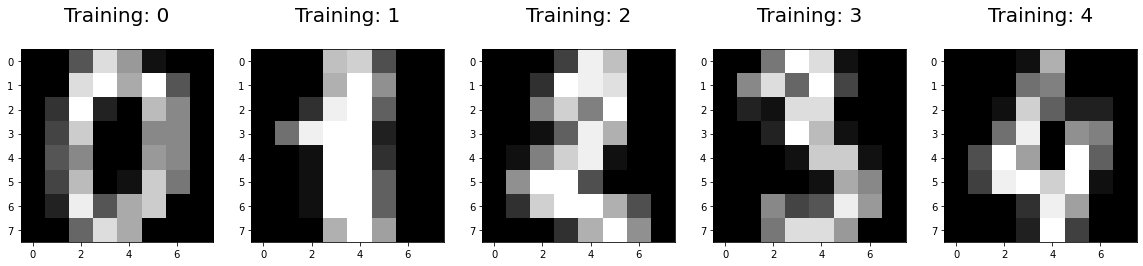

In [78]:
import numpy as np 
import matplotlib.pyplot as plt

plt.figure(figsize=(20,4))
for index, (image, label) in enumerate(zip(digits.data[0:5], digits.target[0:5])):
    plt.subplot(1, 5, index + 1)
    plt.imshow(np.reshape(image, (8,8)), cmap=plt.cm.gray)
    plt.title('Training: %i\n' % label, fontsize = 20)

In [80]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(digits.data, digits.target, test_size=0.25, random_state=0)